In [88]:
from functools import reduce
from os.path import join
from math import log
from scipy.spatial.distance import pdist, squareform
from sklearn.metrics import pairwise_distances

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from upsetplot import from_contents, UpSet

## How to use this notebook

**Input**: Classification table(s) `tool_rank.csv` generated by the short-read taxonomy module.

**Output**: Various graphs of alpha and beta diversity statistics. Summaries of the number of taxa, summed distance metrics, and shared taxon names are generated as part of the process and thus scattered throughout the notebook. 

1) Grouped bar graph of the **numbers of taxa** found in each sample by each classifier at each target taxonomic rank. 

2) Grouped bar graph of the **Shannon entropy** in each sample by each classifier at each target taxonomic rank. The difference between this metric and the previous one is that the presence of each taxon is weighted by its relative abundance (as estimated by the classifier!) in the sample.

3) Histograms of the Shannon entropy found in each sample by each classifier at the rank of phylum. This can be customized for any desired rank. 

4) Set of i) **Bray-Curtis dissimilarity** and ii) **Jaccard distance** heatmaps between each classifier-sample combination (see relevant section for explanation). 

- Note: These are not automatically saved as that would generate many junk figures. It's easiest to go through them from within the notebook and right-click to save the ones that contain meaningful results!

5) Upset plot of **shared taxa** between classifier-sample combination.

- Note: This is not automatically saved either! 

### Steps

**Usage**: There is 1 cell (indicated by the text `Customize here`) that requires user customization, described below. I designed this notebook specifically for the test dataset but tried to generalize as much as possible.

1) Add your work directory, target taxonomic ranks, classification tools used, and sample names to the first cell. 

2) Customize the target rank for the Shannon entropy histograms using `rank_index`. The default is phylum.

### Taxonomic Composition

This simulated dataset is comprised of genetic material from 4 species (selected from the United Human Gut Genome, prioritizing for genome size and prevalence amongst hosts) with 2X Illumina HiSeq 2500 reads. 
- Enterobacter cloacae (MGYG0000000194.9 Mb)
- Roseburia intestinalis (MGYG000000076, 4.2 Mb)
- Bacillus subtilis (MGYG000000012, 4.0 Mb)
- Faecalibacterium prausnitzii_C (MGYG000000022, 3.0 Mb)

In [89]:
# Set seaborn plotting aesthetics as default
sns.set()

In [90]:
# Customize here
# Add the work directory where all of the standardized classification tool CSVs are
work_dir = 'test_data/test_out/short-read-taxonomy/final_reports/'

# Add the taxonomic ranks you want to analyze to the list 
rank_lst = ['species', 'genus', 'family', 'order', 'class', 'phylum']
rank_index = rank_lst.index('phylum') # Replace phylum with any target rank

# Add the classification tools you used to the lists. I like to organize them alphabetically, 
# and organize colours by intensity 
tools_ordered = ['kraken_bracken', 'metaphlan', 'xtree']
tools_labeled = ['Kraken2-Bracken', 'MetaPhlan4', 'XTree']
tools_colours = ['#ffa600', '#dd5182', '#003f5c']

# Add your sample names to lists
samples_ordered = ['uhgg'] 
samples_labeled = ['UHGG'] # Optional- can also be merged_df['sample_name']

# Do not change this! These are 'basic' fields in the standardized report
basic_colnames = ['classifier', 'clade', 'tax_id']

In [91]:
# Merge the standardized classification tool CSVs and check their contents
rank_df_lst = []
for r in rank_lst:
    df_lst = [pd.read_csv(join(work_dir, t + '_' + r + '.csv'), header = 0) for t in tools_ordered]
    merged_df = pd.concat(df_lst)
    print('{} {}'.format(r, merged_df.shape))
    rank_df_lst.append(merged_df)

rank_df_lst[0].iloc[[1,20,80],:]

species (2094, 4)
genus (903, 4)
family (295, 4)
order (157, 4)
class (72, 4)
phylum (47, 4)


,classifier,clade,tax_id,uhgg
1,kraken_bracken,Roseburia sp. NSJ-69,2763062.0,0.004640
20,kraken_bracken,Faecalibacterium sp. HTFF,2929491.0,0.000850
18,xtree,KLE1615 sp905214365,NaN,0.000005


# Short-Read Classification Dataviz

## Alpha Diversity: Within-sample species richness

### Prepare taxon presence-absence tables

In [92]:
# Make a presence-absence dataframe by casting non-zero relative abundances up to 1
pres_abs_df_lst = []
for r in rank_df_lst:
    tmp_df = r.copy()
    for s in samples_ordered:
        tmp_df[s] = [1 if a > 0 else 0 for a in tmp_df[s]]
    pres_abs_df_lst.append(tmp_df)

pres_abs_df_lst[0].iloc[[1,20,80],:]

,classifier,clade,tax_id,uhgg
1,kraken_bracken,Roseburia sp. NSJ-69,2763062.0,1
20,kraken_bracken,Faecalibacterium sp. HTFF,2929491.0,1
18,xtree,KLE1615 sp905214365,NaN,1


In [93]:
# Sum the presence-absences of all taxa for each classifier-sample combination
# The result is the number of taxa found in each sample by each classifier
agg_dct = {}
for c in basic_colnames:
    agg_dct[c] = 'first'
for c in samples_ordered:
    agg_dct[c] = 'sum'

agg_rank_df_lst = []
for r in pres_abs_df_lst:
    tmp = r.groupby(r['classifier']).aggregate(agg_dct)
    tmp.drop(columns = basic_colnames, inplace = True)
    tmp.reset_index(inplace = True)
    agg_rank_df_lst.append(tmp)

agg_rank_df_lst[0]

,classifier,uhgg
0,kraken_bracken,59
1,metaphlan,3
2,xtree,2032


In [94]:
# Melt the sample columns together for a flatter dataframe
melt_rank_df_lst = []
for r in agg_rank_df_lst:
    tmp = r.melt( id_vars = ['classifier'], 
            value_vars = samples_ordered,
            var_name = 'sample_name', value_name = 'pres_abs' )
    melt_rank_df_lst.append(tmp)

melt_rank_df_lst[0]

,classifier,sample_name,pres_abs
0,kraken_bracken,uhgg,59
1,metaphlan,uhgg,3
2,xtree,uhgg,2032


### Numbers of taxa per classifier-sample combination

In [95]:
def grouped_bar_plot(df, r, a, parameter):
    # p = pres_abs or shannon
    p = sns.barplot(data = df, x = 'sample_name', y = parameter, hue = 'classifier', \
                    order = samples_ordered, palette = tools_colours, ax = a)
    p.set_xticklabels(samples_labeled, size = 12) #, rotation = 45, ha = 'right') # Relabel each of the groups
    p.set(xlabel = r.capitalize(), ylabel = None) # Turns off y-axis label for each subplot, but labels the x-axis the rank
    p.get_legend().remove()
    return p

In [96]:
%%capture
# To suppress figure output
# Define plotting region 
num_rows = 2
num_cols = int(len(rank_lst) / num_rows)
fig, axs = plt.subplots(num_rows, num_cols, figsize = (24,12)) # in.

In [97]:
# Plot the number of taxa identified by each combination of classification tool and sample
for i, df in enumerate(melt_rank_df_lst):
    row = int(i // num_cols)
    col = int(i % num_cols)
    grouped_bar_plot(df, rank_lst[i], axs[row,col], 'pres_abs')
    axs[row,0].set_ylabel('Num. Clades', size = 16)

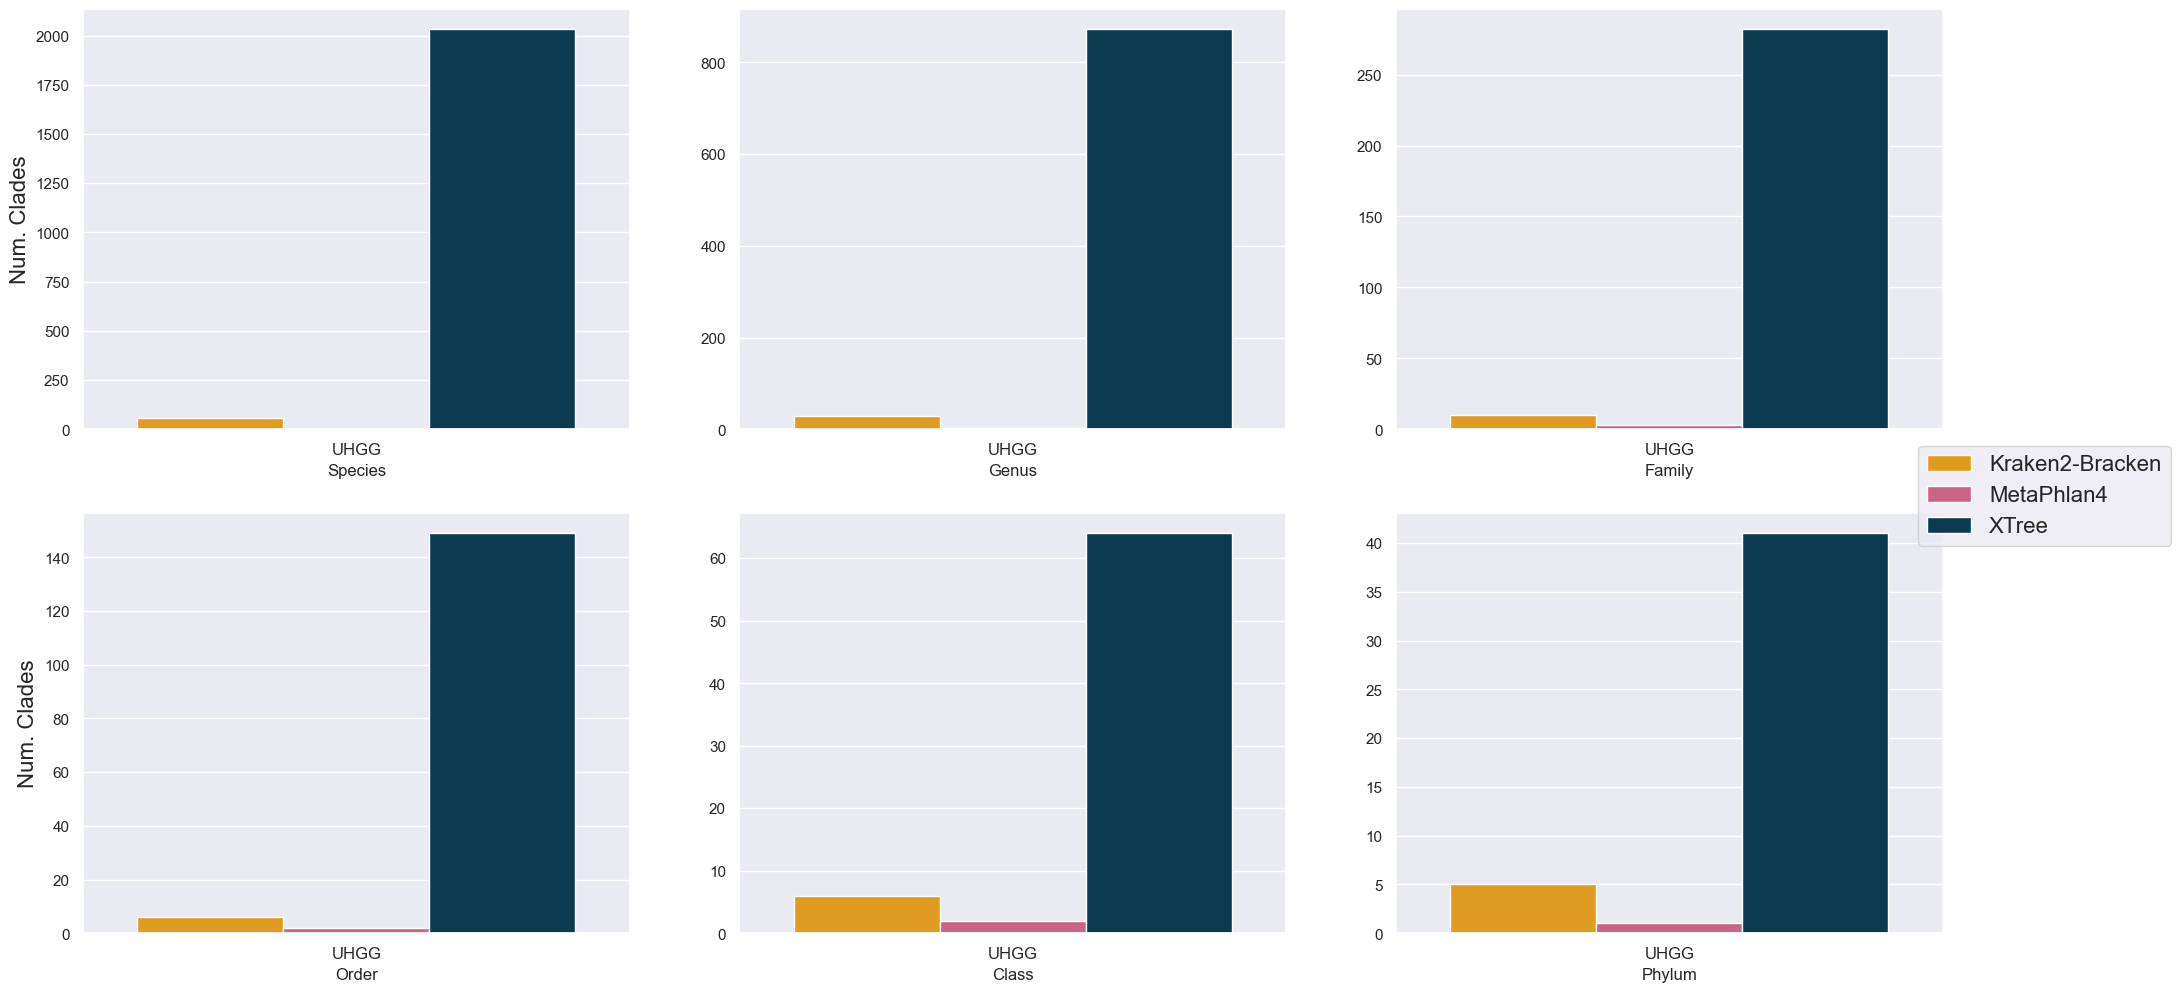

In [98]:
# Add a global legend and plot the graph
handles, labels = axs[0,0].get_legend_handles_labels()
fig.legend(handles, tools_labeled, loc = 'center right', fontsize = 16)
fig

In [99]:
# Save a large SVG without padding
fig.savefig('rank_tool_sample_num_taxa.svg', dpi = 1000, bbox_inches = 'tight')

### Shannon entropy per classifier-sample combination

The Shannon Index is an estimator for both species richness and evenness (i.e.: diversity), but with weight on the richness. The idea behind this metric is that the more species you observe, and the more even their abundances are, the higher the entropy, or the higher the uncertainty of predicting which species you would see next if you were to look at another read from this sample.
Source: https://docs.onecodex.com/en/articles/4136553-alpha-diversity 

In [100]:
def shannon_index(row):
    s_lst = []
    for s in range(len(samples_ordered)):
        if row[3 + s] == 0:
            s_lst.append(0)
        else:
            s_lst.append(-log(row[3 + s])*row[3 + s])
    return list(row[0:3]) + s_lst

In [101]:
# Calculate H for each classifier-sample combination
h_rel_abund_lst = []
for i,r in enumerate(rank_df_lst):
    tmp_lst = list(r.apply(lambda row : shannon_index(row), axis = 1))
    tmp_df = pd.DataFrame(tmp_lst, columns = basic_colnames + samples_ordered)
    print('{} {}'.format(rank_lst[i], tmp_df.shape))
    h_rel_abund_lst.append(tmp_df)

h_rel_abund_lst[0].iloc[[1,20,80],:]

species (2094, 4)
genus (903, 4)
family (295, 4)
order (157, 4)
class (72, 4)
phylum (47, 4)


,classifier,clade,tax_id,uhgg
1,kraken_bracken,Roseburia sp. NSJ-69,2763062.0,0.024931
20,kraken_bracken,Faecalibacterium sp. HTFF,2929491.0,0.006010
80,xtree,KLE1615 sp905214365,NaN,0.000061


In [102]:
# Sum H for each classifier-sample combination
agg_dct = {}
for c in basic_colnames:
    agg_dct[c] = 'first'
for c in samples_ordered:
    agg_dct[c] = 'sum'

shan_rank_df_lst = []
for i, r in enumerate(h_rel_abund_lst):
    tmp_df = r.groupby(r['classifier']).aggregate(agg_dct)
    tmp_df.drop(columns = basic_colnames, inplace = True)
    tmp_df.reset_index(inplace = True)
    shan_rank_df_lst.append(tmp_df)
    print('{} {}'.format(rank_lst[i], tmp_df.shape))

shan_rank_df_lst[0]

species (3, 2)
genus (3, 2)
family (3, 2)
order (3, 2)
class (3, 2)
phylum (3, 2)


,classifier,uhgg
0,kraken_bracken,2.275409
1,metaphlan,0.791721
2,xtree,3.013875


In [103]:
# Melt the sample columns together for a flatter dataframe
melt_shan_df_lst = []
for r in shan_rank_df_lst:
    tmp = r.melt( id_vars = ['classifier'], 
            value_vars = samples_ordered,
            var_name = 'sample_name', value_name = 'shannon' )
    melt_shan_df_lst.append(tmp)

melt_shan_df_lst[0]

,classifier,sample_name,shannon
0,kraken_bracken,uhgg,2.275409
1,metaphlan,uhgg,0.791721
2,xtree,uhgg,3.013875


In [104]:
%%capture
# To suppress figure output
# Define plotting region
num_rows = 2
num_cols = int(len(rank_lst) / num_rows)
fig, axs = plt.subplots(num_rows, num_cols, figsize = (24,12)) # in.

In [105]:
# Plot the number of taxa identified by each combination of classification tool and sample
for i, df in enumerate(melt_shan_df_lst):
    row = int(i // num_cols)
    col = int(i % num_cols)
    grouped_bar_plot(df, rank_lst[i], axs[row,col], 'shannon')
    axs[row,0].set_ylabel('Shannon Index (H)', size = 16)

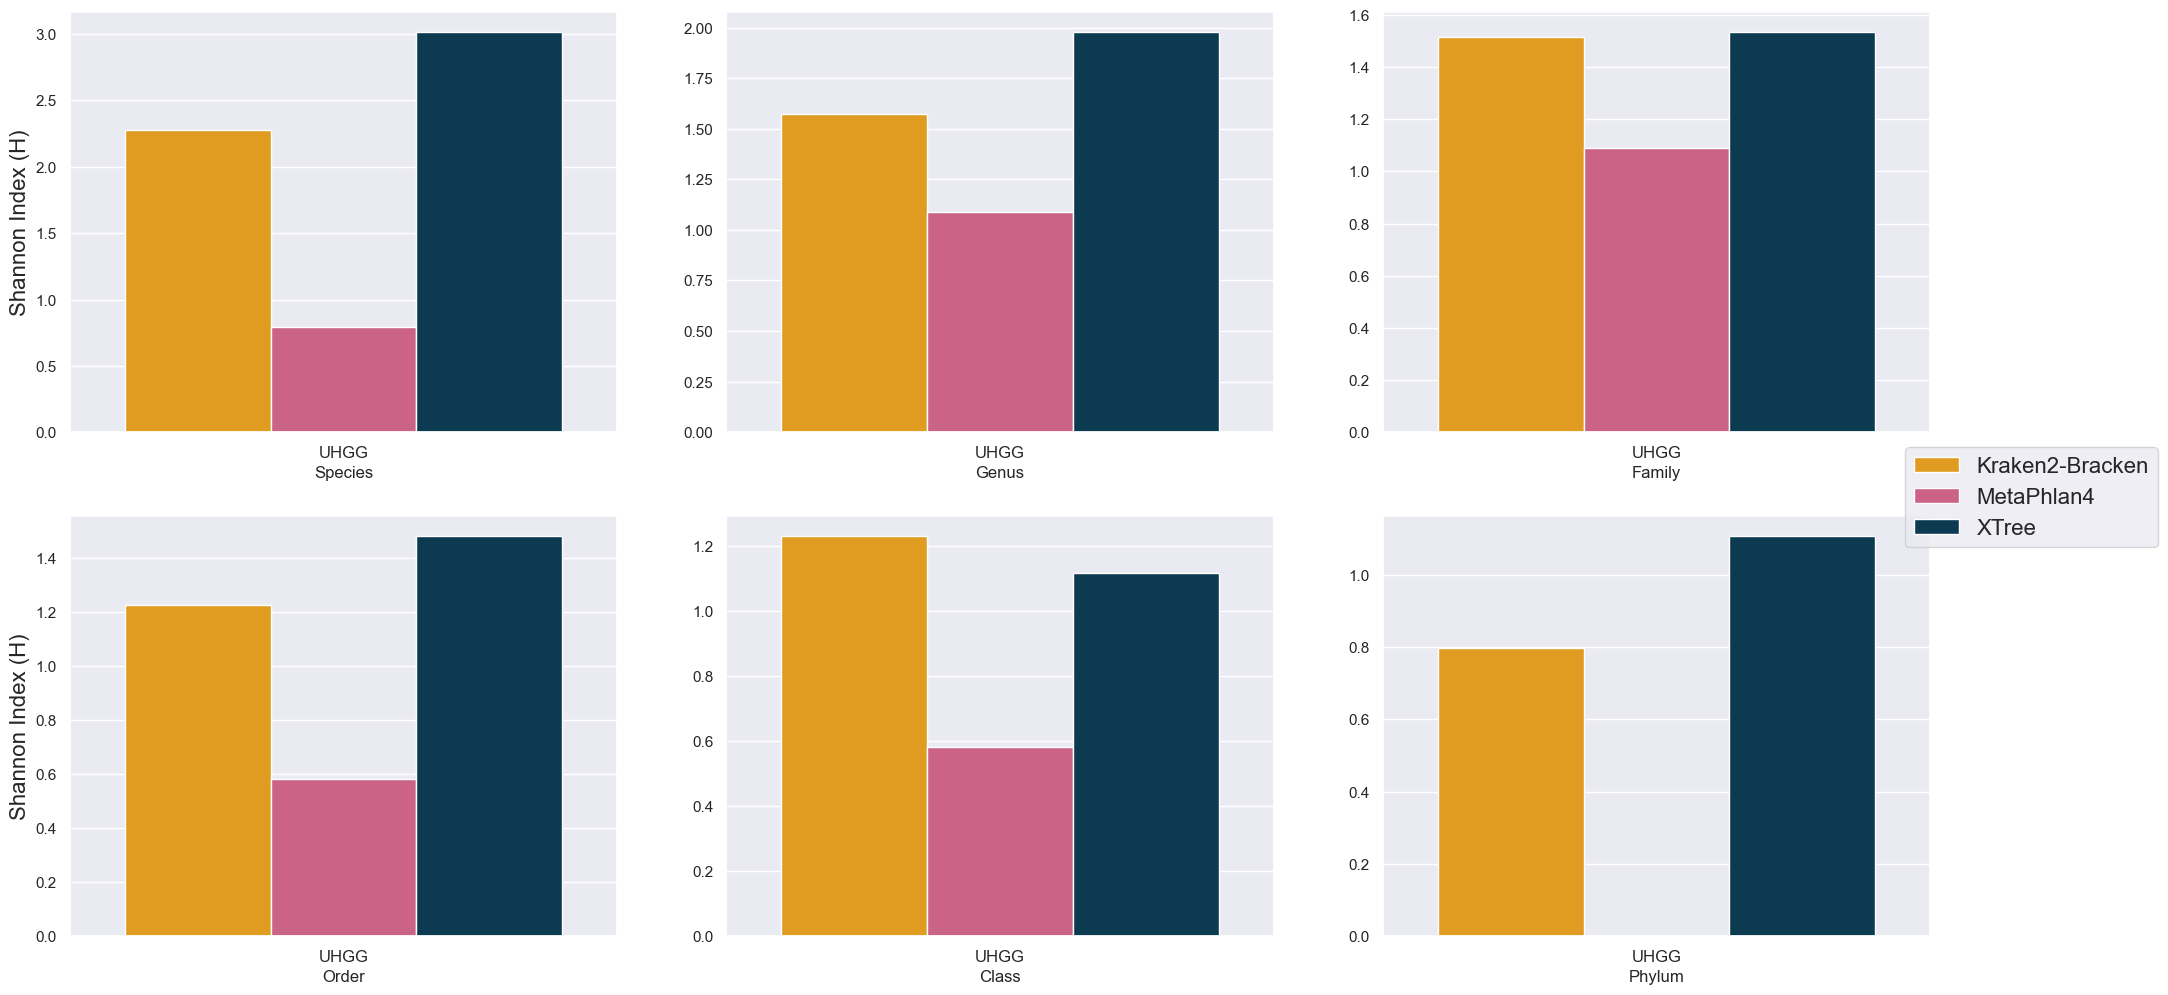

In [106]:
# Add a global legend and plot the graph
handles, labels = axs[0,0].get_legend_handles_labels()
fig.legend(handles, tools_labeled, loc = 'center right', fontsize = 16)
fig

In [107]:
# Save a large SVG without padding
fig.savefig('rank_tool_sample_shan_h.svg', dpi = 1000, bbox_inches = 'tight')

#### Shannon entropy histograms for each classifier-sample combination at the phylum rank

In [108]:
%%capture
# To suppress figure output
# Define plotting region
num_rows = len(tools_ordered)
num_cols = len(samples_ordered)
fig, axs = plt.subplots(num_rows, num_cols, figsize = (12,12)) # in.

In [109]:
def hist_plot(lst, x_label, c, a):
    p = sns.histplot(data = lst, color = c, ax = a, bins = 12)
    p.set_xlim(0.0,0.4)
    p.set(xlabel = x_label, ylabel = None) # Turns off y-axis label for each subplot, but labels the x-axis the rank
    return p

In [110]:
# Plot the phylum Shannon indices for each classifier-sample combination
phylum_h_df = h_rel_abund_lst[rank_index]
for i, t in enumerate(tools_ordered): # 0,1,2 % 3
    sub_df = phylum_h_df[phylum_h_df['classifier'] == t]
    for j, s in enumerate(samples_ordered):
        sub_lst = list(sub_df[s])
        a = axs[i,j] if num_cols > 1 else axs[i]
        hist_plot(sub_lst, samples_labeled[j], tools_colours[i], a)
    if num_cols > 1: 
        axs[i,0].set_ylabel(tools_labeled[i], size = 16)
    else:
        axs[i].set_ylabel(tools_labeled[i], size = 16)

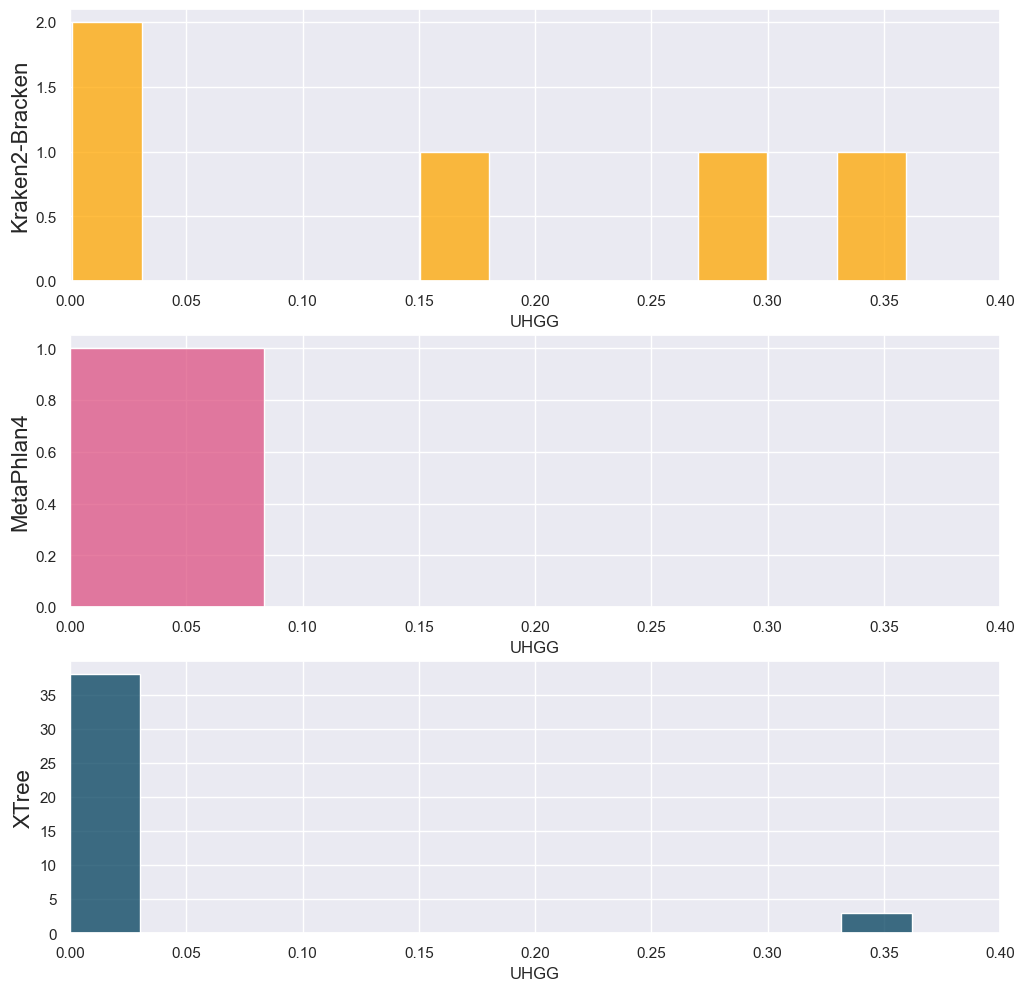

In [111]:
fig

In [112]:
# Save a large SVG without padding
fig.savefig('phylum_tool_sample_shan_hist.svg', dpi = 1000, bbox_inches = 'tight')

## Beta Diversity: Between-sample species diversity

Beta diversity is a term used to express the differences between samples or environments. Bray-Curtis dissimilarity examines the abundances of microbes that are shared between two samples, and the number of microbes found in each. Bray-Curtis dissimilarity ranges from 0 to 1. Like Bray-Curtis dissimilarity, the Jaccard distance is also bounded between 0 and 1. Also like Bray-Curtis dissimilarity, it should be considered a "dissimilarity" as opposed to a true "distance". However Jaccard distance does not take abundances into account; just the presence of microbes in one or both samples.

Source: https://docs.onecodex.com/en/articles/4150649-beta-diversity

### Preparing classifier-sample dataframes

In [113]:
# Convert the raw relative abundance dataframes into classifier-sample relative abundance 
# dataframes by merging the sample and classifier columns so that each combination has its
# own column. Here, I have 1 sample and 3 classifiers so there are 3 combinations in total. 
rank_bcd_nona_lst = []
rank_bcd_zero_lst = []
rank_jcd_lst = []
cmb_ra_lst = []
for i,r in enumerate(rank_df_lst):
    ra_df = r.copy()
    cmb_lst = []
    for j,t in enumerate(tools_ordered):
        sub_df = ra_df[ra_df['classifier'] == t].copy()
        sub_df.columns = ['tmp', 'clade', 'tax_id'] + [k + ' ' + tools_labeled[j] for k in samples_labeled]
        cmb_lst.append(sub_df)
    # Merge combos together on the taxonomic ID column
    cmb_df = reduce(lambda left,right: pd.merge(left, right, on = ['clade', 'tax_id'], how = 'outer'), cmb_lst) #.fillna(0.0)
    # Get rid of all of the other 'tmp' columns
    cmb_df.drop(['tmp','tmp_x','tmp_y','tax_id'], axis = 1, inplace = True)
    print('{} {}'.format(rank_lst[i], cmb_df.shape))
    cmb_ra_lst.append(cmb_df)
    
cmb_ra_lst[0].iloc[[1,20,80],:]

species (2066, 4)
genus (882, 4)
family (285, 4)
order (151, 4)
class (66, 4)
phylum (43, 4)


,clade,UHGG Kraken2-Bracken,UHGG MetaPhlan4,UHGG XTree
1,Roseburia sp. NSJ-69,0.00464,NaN,NaN
20,Faecalibacterium sp. HTFF,0.00085,NaN,NaN
80,Scatomorpha sp900752445,NaN,NaN,0.00003


### Bray-Curtis dissimilarity measuring relative abundance

In [114]:
# Make the Bray-Curtis dissimilarity matrices based on either shared or all taxa 
rank_bcd_nona_lst = []
rank_bcd_zero_lst = []
for i,r in enumerate(cmb_ra_lst):
    cmb_df = r.copy()
    cmb_df.drop(['clade'], axis = 1, inplace = True)
    # Option 1: Get rid of NA columns
    reduced_df = cmb_df.dropna()
    # Transpose the dataframe so that each row is a combo
    t_ra_df = reduced_df.transpose()
    bcd_df = pd.DataFrame(squareform(pdist(t_ra_df, 'braycurtis')), index = t_ra_df.index, columns = t_ra_df.index)
    rank_bcd_nona_lst.append(bcd_df)
    # Option 2: Fill NA with 0
    filled_df = cmb_df.fillna(0.0)
    # Transpose the dataframe so that each row is a combo
    t_ra_df = filled_df.transpose()
    bcd_df = pd.DataFrame(squareform(pdist(t_ra_df, 'braycurtis')), index = t_ra_df.index, columns = t_ra_df.index)
    rank_bcd_zero_lst.append(bcd_df)

rank_bcd_nona_lst[0].iloc[0:3,0:3]

,UHGG Kraken2-Bracken,UHGG MetaPhlan4,UHGG XTree
UHGG Kraken2-Bracken,0.000000,0.694427,0.176811
UHGG MetaPhlan4,0.694427,0.000000,0.739987
UHGG XTree,0.176811,0.739987,0.000000


In [115]:
rank_bcd_zero_lst[0].iloc[0:3,0:3]

,UHGG Kraken2-Bracken,UHGG MetaPhlan4,UHGG XTree
UHGG Kraken2-Bracken,0.000000,0.759531,0.711645
UHGG MetaPhlan4,0.759531,0.000000,0.800755
UHGG XTree,0.711645,0.800755,0.000000


In [116]:
def cluster_map(df, r):
    p = sns.clustermap(df, cmap = 'rocket', figsize = (6,6))
    p.ax_heatmap.set_xlabel(r.capitalize())
    # Adjust x,y position (0,0 is lower left)  and size of colour-bar legend
    p.ax_cbar.set_position((0.08,0.83,0.03,0.13)) 
    return p

/Users/laurenmak/opt/miniconda3/envs/dataviz/lib/python3.10/site-packages/seaborn/matrix.py:624: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  linkage = hierarchy.linkage(self.array, method=self.method,


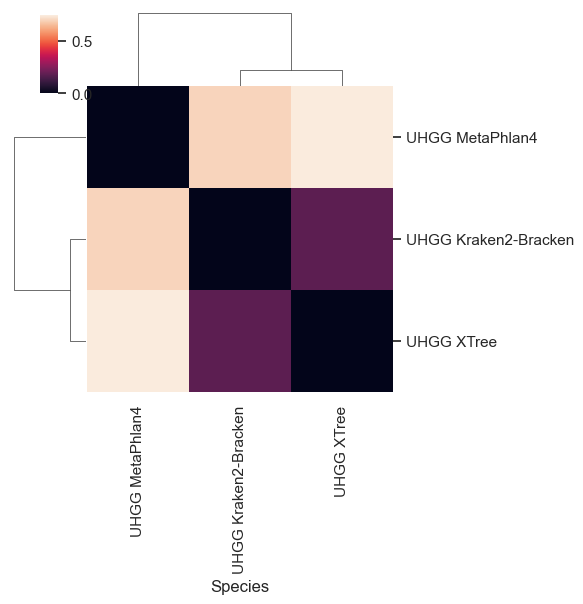

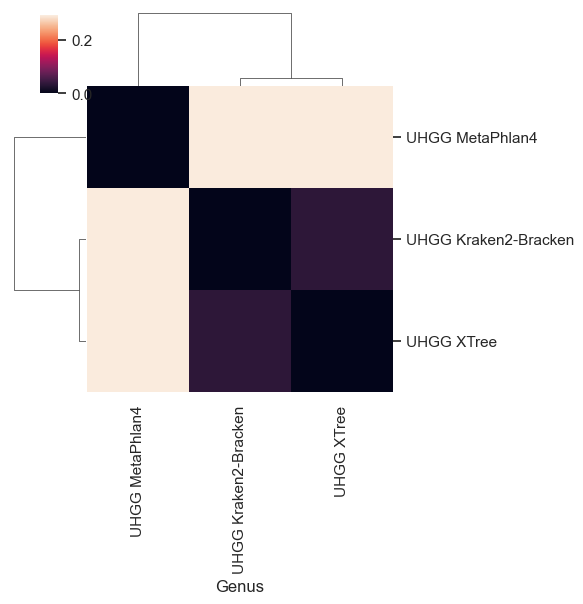

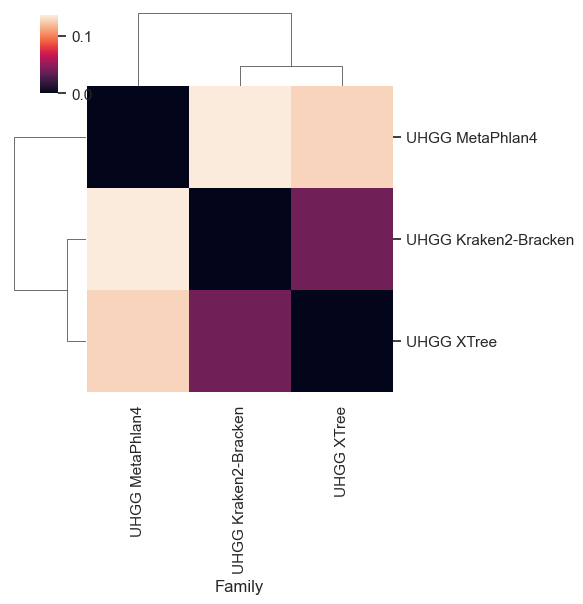

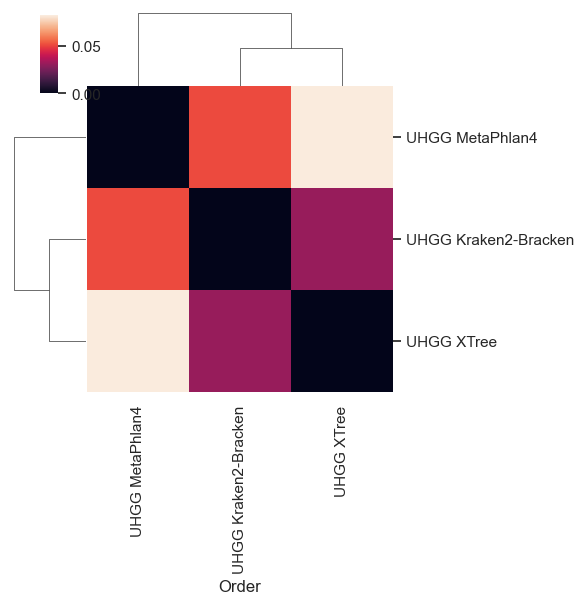

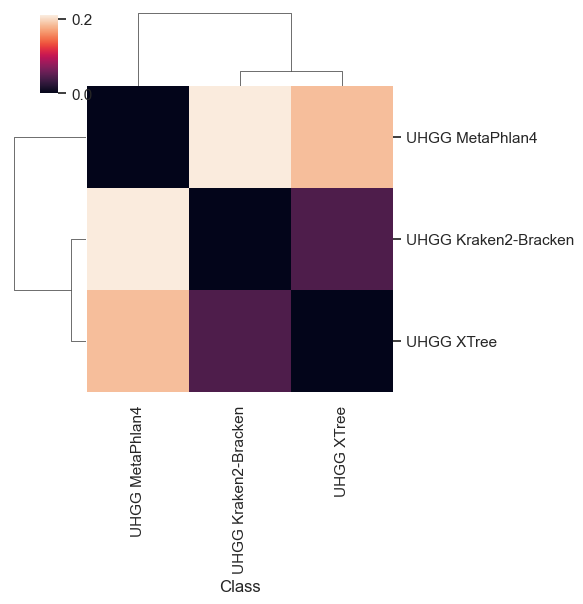

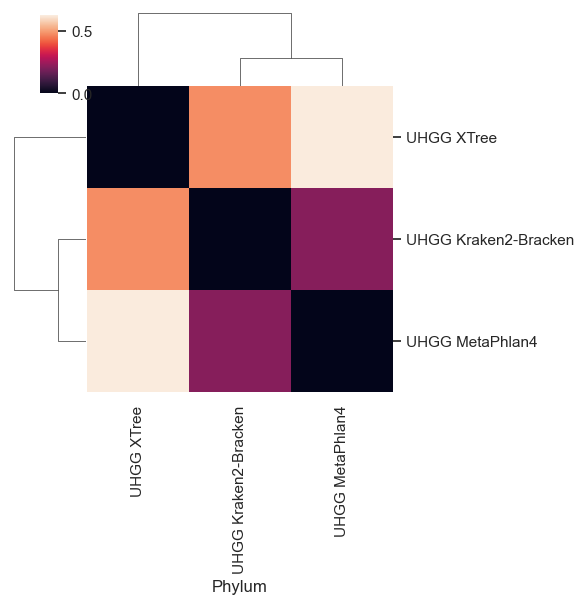

In [117]:
# Plot the Bray-Curtis dissimilarity between each combination of classification tool and  
# sample (only shared taxa)
for i, df in enumerate(rank_bcd_nona_lst):
    cluster_map(df, rank_lst[i])

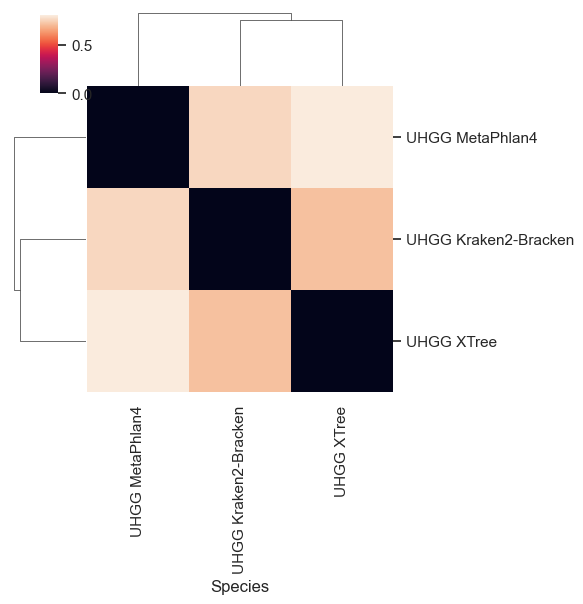

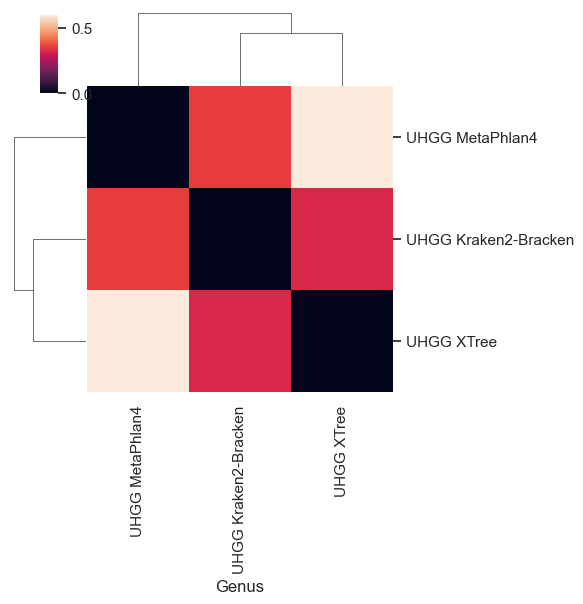

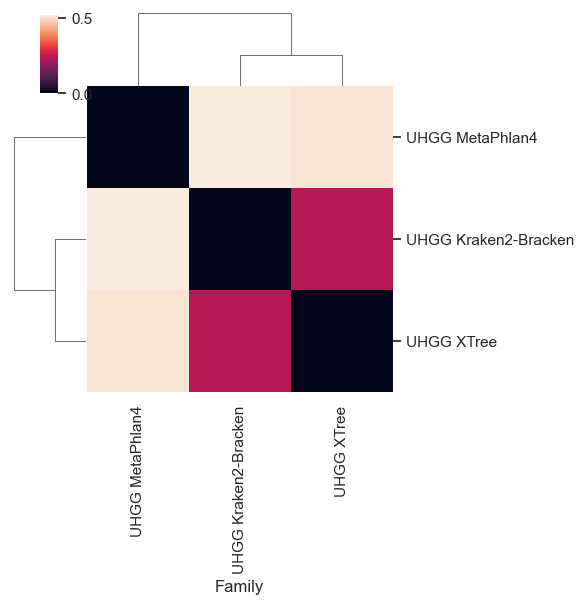

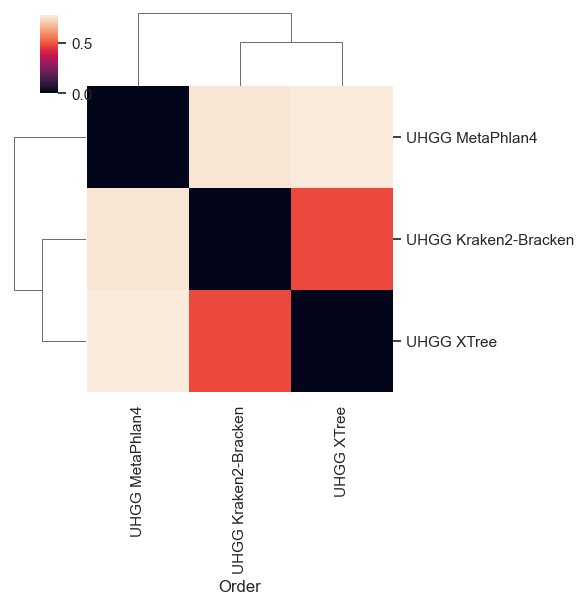

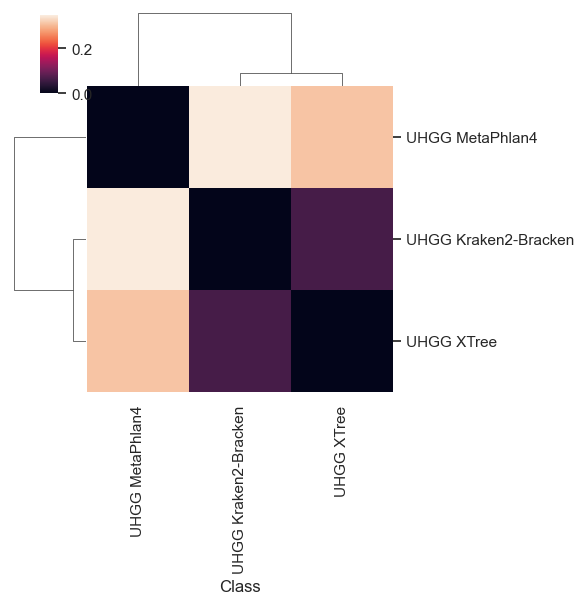

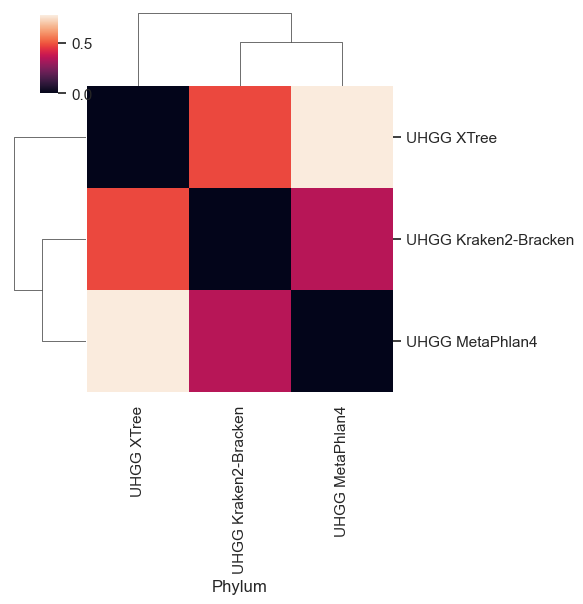

In [118]:
# Plot the Bray-Curtis dissimilarity between each combination of classification tool and 
# sample (all available taxa)
for i, df in enumerate(rank_bcd_zero_lst):
    cluster_map(df, rank_lst[i])

### Jaccard difference measuring presence-absence

In [119]:
# Make the Jaccard difference matrices based on either shared or all taxa 
rank_pa_lst = []
rank_jcd_lst = []
for i,r in enumerate(cmb_ra_lst):
    cmb_df = r.copy()
    # Make a presence-absence dataframe 
    for s in cmb_df.columns[1:]:
        cmb_df[s] = [1 if a > 0 else 0 for a in cmb_df[s]]
    rank_pa_lst.append(cmb_df)
    cleaned_df = cmb_df.drop(['clade'], axis = 1)
    t_pa_df = cleaned_df.transpose()
    jcd_df = pd.DataFrame(squareform(pdist(t_pa_df, 'jaccard')), index = t_pa_df.index, columns = t_pa_df.index)
    rank_jcd_lst.append(jcd_df)

rank_jcd_lst[0].iloc[0:3,0:3]

,UHGG Kraken2-Bracken,UHGG MetaPhlan4,UHGG XTree
UHGG Kraken2-Bracken,0.000000,0.949153,0.987899
UHGG MetaPhlan4,0.949153,0.000000,0.998524
UHGG XTree,0.987899,0.998524,0.000000


/Users/laurenmak/opt/miniconda3/envs/dataviz/lib/python3.10/site-packages/seaborn/matrix.py:624: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  linkage = hierarchy.linkage(self.array, method=self.method,


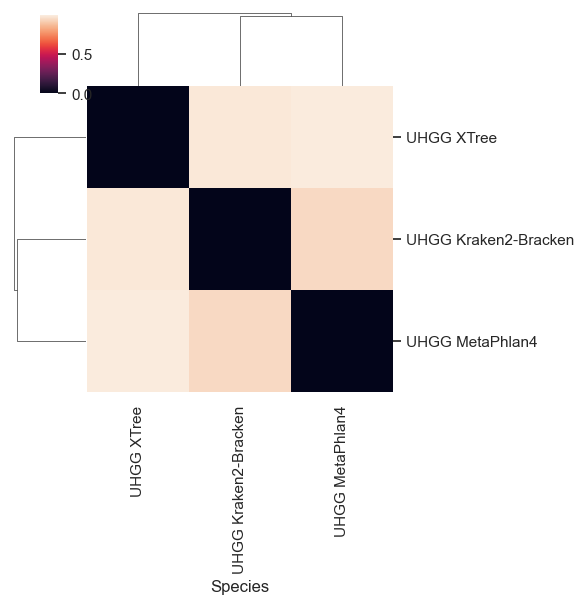

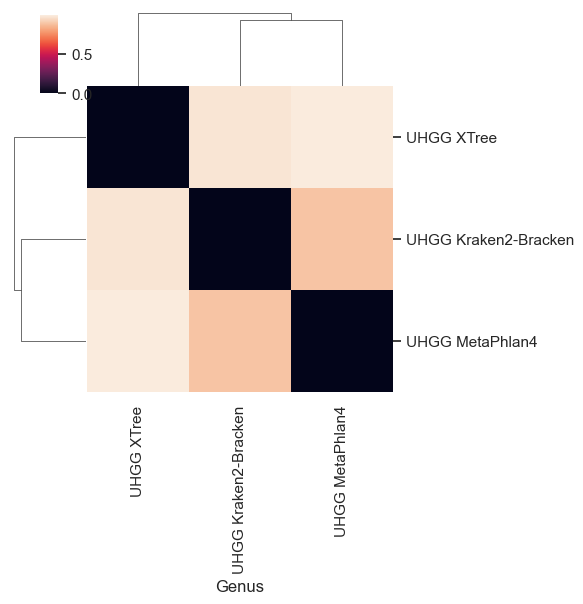

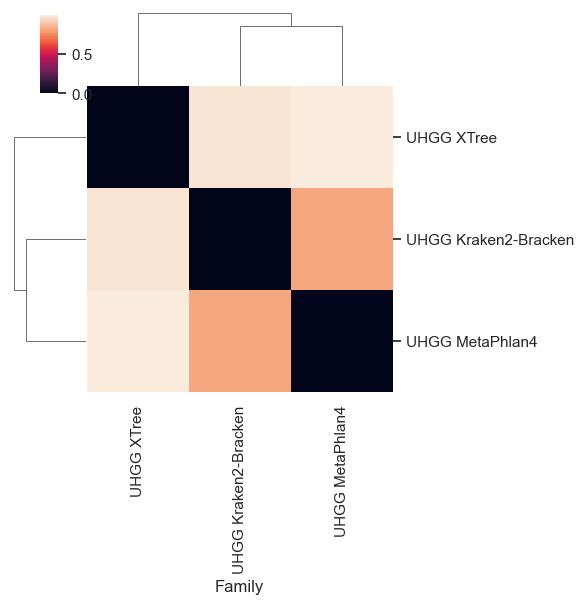

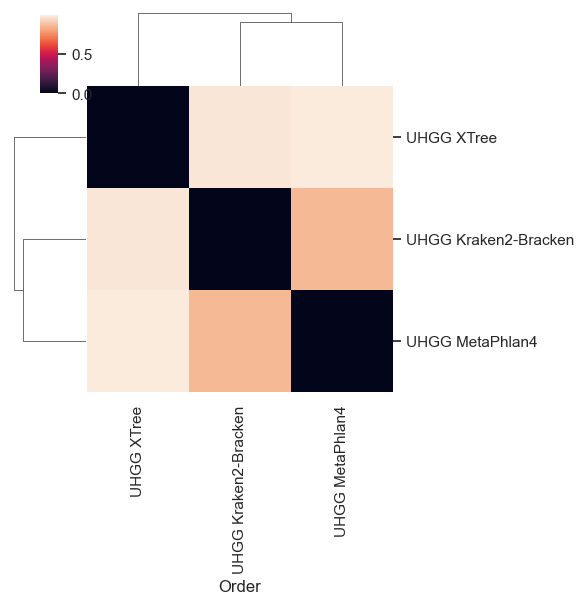

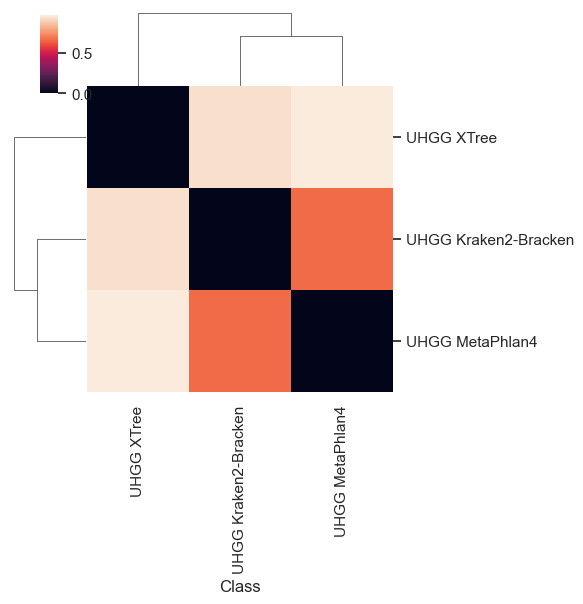

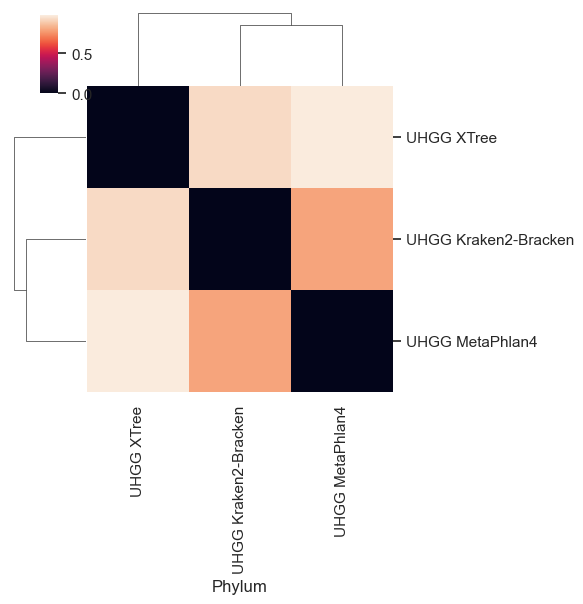

In [120]:
# Plot the Jaccard difference between each combination of classification tool and sample
for i, df in enumerate(rank_jcd_lst):
    cluster_map(df, rank_lst[i])

### Taxa sharing between classifier-sample combinations

In [121]:
# Get the phylum presence-absence dataframe
phylum_pa_df = rank_pa_lst[rank_index].copy()
phylum_pa_df.set_index('clade', inplace = True)
phylum_pa_df = phylum_pa_df.transpose()
print('{}'.format(phylum_pa_df.shape))
phylum_pa_df.iloc[:,[1,20,40]]

(3, 43)


clade,Actinobacteria,Firmicutes B,Thermotogota
UHGG Kraken2-Bracken,1,0,0
UHGG MetaPhlan4,0,0,0
UHGG XTree,0,1,1


In [122]:
def make_upset_df(raw_df):
    combo_names = list(raw_df.index)
    cmb_dct = raw_df.to_dict(orient = 'list')
    new_dct = {}
    for k,v in cmb_dct.items():
        new_dct[k] = []
        for j,pa in enumerate(v):
            if pa == 1:
                new_dct[k].append(combo_names[j])
    return new_dct

In [123]:
# Convert the presence-absence dataframes into upset plot-compatible dataframes 
# Here, I've divided the phyla up by the number of samples the phylum appeared in
phylum_cmb_lst = []
num_cmbs = phylum_pa_df.shape[0]
for i in range(1,num_cmbs + 1):
    tmp_df = phylum_pa_df.loc[:,(phylum_pa_df.sum(axis = 0) == i)]
    phylum_cmb_dct = make_upset_df(tmp_df)
    print('In {} samples: {} phyla: {}'.format(i, len(phylum_cmb_dct.keys()), list(phylum_cmb_dct.keys())))
    if phylum_cmb_dct:
        phylum_cmb_lst.append(from_contents(phylum_cmb_dct))

phylum_cmb_lst[-1]

In 1 samples: 40 phyla: ['Actinobacteria', 'Chordata', 'Acidobacteriota', 'Actinobacteriota', 'Asgardarchaeota', 'Bdellovibrionota', 'Caldisericota', 'Campylobacterota', 'Chlamydiota', 'Chloroflexota', 'Cyanobacteria', 'Dependentiae', 'Desulfobacterota', 'Desulfobacterota I', 'Elusimicrobiota', 'Eremiobacterota', 'Firmicutes A', 'Firmicutes B', 'Firmicutes C', 'Firmicutes D', 'Firmicutes E', 'Fusobacteriota', 'Halobacteriota', 'Margulisbacteria', 'Methanobacteriota', 'Methanobacteriota A', 'Methanobacteriota B', 'Myxococcota', 'Myxococcota A', 'Nanoarchaeota', 'OLB16', 'Omnitrophota', 'Patescibacteria', 'Planctomycetota', 'SZUA-79', 'Spirochaetota', 'Thermoproteota', 'Thermotogota', 'UBA10199', 'Verrucomicrobiota']
In 2 samples: 2 phyla: ['Proteobacteria', 'Bacteroidota']
In 3 samples: 1 phyla: ['Firmicutes']


,id
Firmicutes,
True,UHGG Kraken2-Bracken
True,UHGG MetaPhlan4
True,UHGG XTree


In [124]:
# Make an upset plot for phyla that appear in a majority of the samples 
tmp_df = phylum_pa_df.loc[:,(phylum_pa_df.sum(axis = 0) > num_cmbs // 2)]
phylum_cmb_dct = make_upset_df(tmp_df)
phylum_cmb_df = from_contents(phylum_cmb_dct)
print('In a majority of samples: {} phyla: {}'.format(len(phylum_cmb_dct.keys()), list(phylum_cmb_dct.keys())))

In a majority of samples: 3 phyla: ['Firmicutes', 'Proteobacteria', 'Bacteroidota']


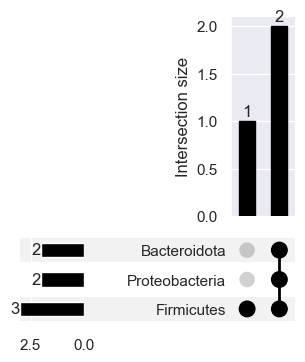

In [125]:
UpSet(phylum_cmb_df, show_counts = True)

In [126]:
# Additional dataframe exploration
# MetaPhlan seems to get closest to the actual composition- all 3 species are true-positives 
# and their relative abundances are fairly accurate. Only 1 is completely missed at all 
# taxonomic levels.
for r in rank_df_lst:
    print(r[r['classifier'] == 'metaphlan'])

  classifier                         clade    tax_id      uhgg
0  metaphlan             Bacillus subtilis    1423.0  0.538641
1  metaphlan  Faecalibacterium prausnitzii     853.0  0.722799
2  metaphlan        Roseburia intestinalis  166486.0  0.738560
  classifier             clade    tax_id      uhgg
0  metaphlan          Bacillus    1386.0  0.269321
1  metaphlan  Faecalibacterium  216851.0  0.361399
2  metaphlan         Roseburia     841.0  0.369280
  classifier            clade    tax_id      uhgg
0  metaphlan      Bacillaceae  186817.0  0.269321
1  metaphlan  Lachnospiraceae  186803.0  0.369280
2  metaphlan  Ruminococcaceae  541000.0  0.361399
  classifier          clade    tax_id      uhgg
0  metaphlan     Bacillales    1385.0  0.269321
1  metaphlan  Clostridiales  186802.0  0.730679
  classifier       clade    tax_id      uhgg
0  metaphlan     Bacilli   91061.0  0.269321
1  metaphlan  Clostridia  186801.0  0.730679
  classifier       clade  tax_id  uhgg
0  metaphlan  Firmicutes  

In [127]:
# However, both Kraken-Bracken and XTree find it, with Kraken-Bracken getting closest to its
# actual relative abundance.
rank_df_lst[0][rank_df_lst[0]['clade'] == 'Enterobacter cloacae'] 

,classifier,clade,tax_id,uhgg
52,kraken_bracken,Enterobacter cloacae,550.0,0.292760
50,xtree,Enterobacter cloacae,550.0,0.003862
